In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import pydrake
import os
import sys
import time
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_model import *

In [2]:
seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()


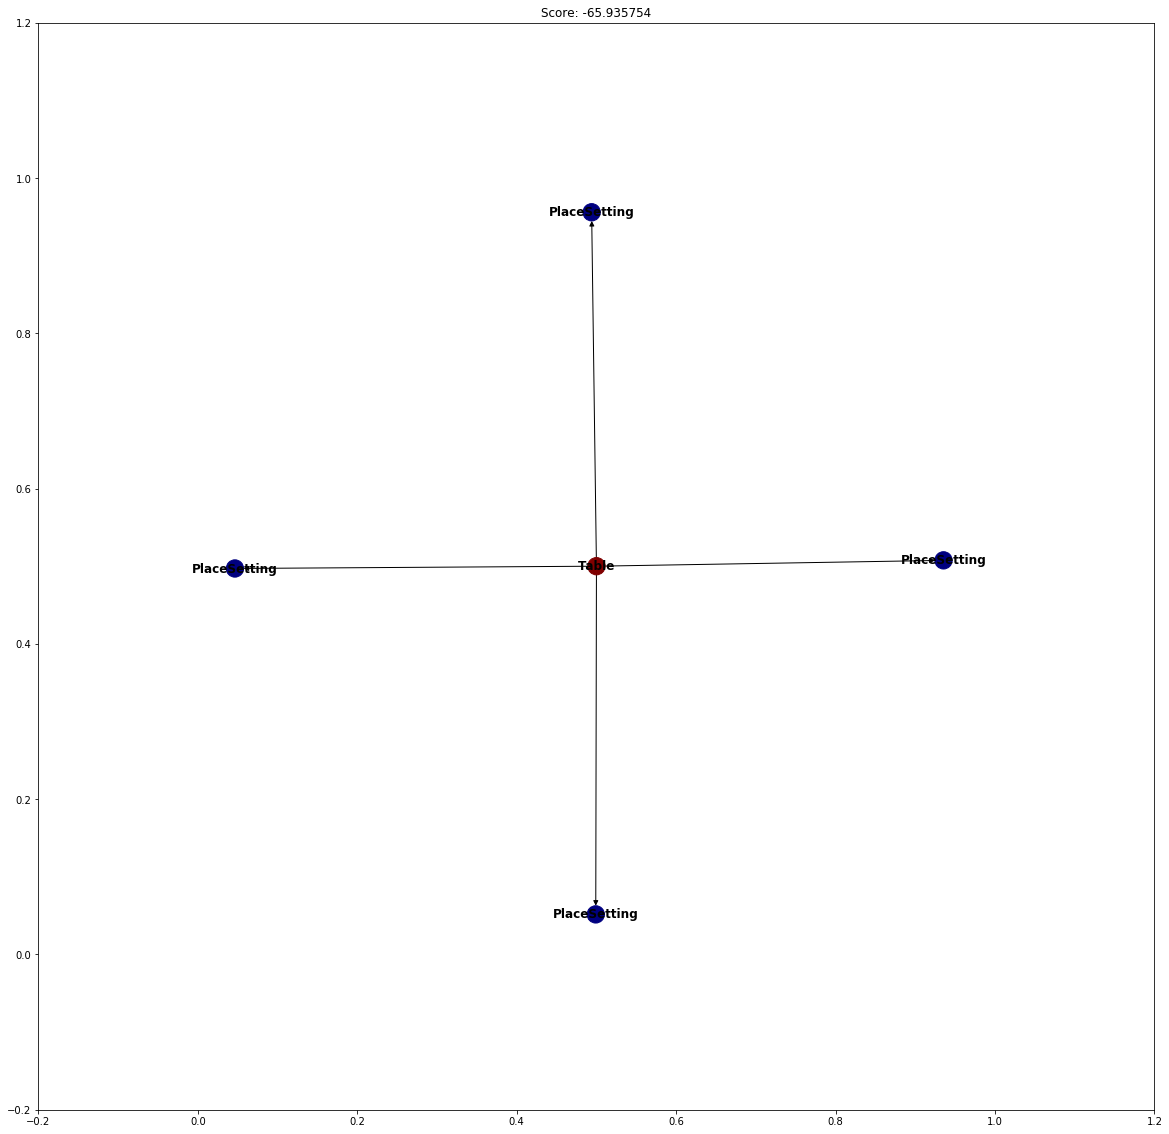

In [3]:
plt.figure().set_size_inches(20, 20)
hyper_parse_tree = generate_hyperexpanded_parse_tree()
draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)

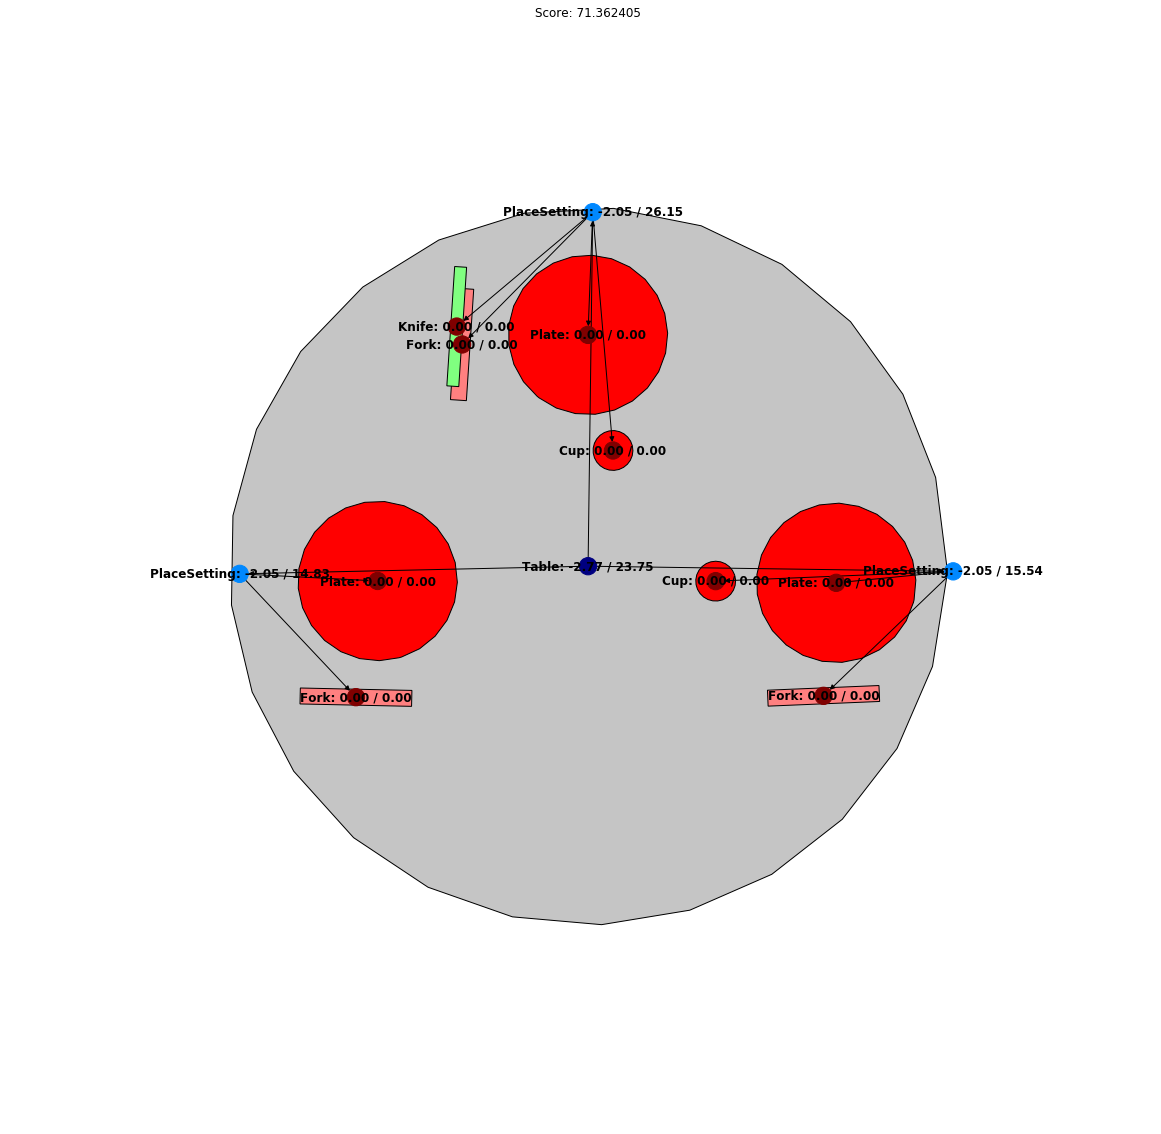

In [4]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
yaml_env = convert_tree_to_yaml_env(parse_tree)
DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
draw_parse_tree(parse_tree, label_name=True, label_score=True)

In [5]:
# Clear gradients
for param_name in pyro.get_param_store():
    pyro.param(param_name).grad = None
# Calc gradients of score w.r.t. all params
trace = poutine.trace(rerun_conditioned_parse_tree).get_trace(
    parse_tree, score_terminal_products=True, score_nonterminal_products=True)
score = trace.log_prob_sum()
print("score: ", score)
score.backward(retain_graph=True)
def print_param_store(grads=False):
    for param_name in pyro.get_param_store().keys():
        val = pyro.param(param_name)#.tolist()
        grad = pyro.param(param_name).grad
        #if isinstance(val, float):
        #    val = [val]
        if grads:
            print(param_name, ": ", val.data, ", unconstrained grad: ", pyro.get_param_store()._params[param_name].grad)
        else:
            print(param_name, ": ", val.data)
print_param_store(grads=True)
fork_node = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
#print(list(parse_tree.predecessors(fork_node))[0].offset_dist.scale)

score:  tensor(71.3624, grad_fn=<AddBackward0>)
place_setting_left_knife_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_left_fork_mean :  tensor([-0.1500,  0.1600,  0.0000]) , unconstrained grad:  tensor([ 5.6743, 88.3264, 13.3529])
place_setting_right_spoon_mean :  tensor([0.1500, 0.1600, 0.0000]) , unconstrained grad:  None
place_setting_right_spoon_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_plate_var :  tensor([0.0100, 0.0100, 3.0000]) , unconstrained grad:  tensor([-1.6609,  0.6712, -0.6737])
place_setting_left_spoon_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstrained grad:  None
place_setting_plate_mean :  tensor([0.0000, 0.1600, 0.0000]) , unconstrained grad:  tensor([-80.5042, -55.4825,   0.6406])
place_setting_right_knife_mean :  tensor([0.1500, 0.1600, 0.0000]) , unconstrained grad:  tensor([104.6682, -52.5552,  25.8204])
place_setting_right_fork_var :  tensor([0.0100, 0.0100, 0.0100]) , unconstraine

In [6]:
fork = next(obj for obj in parse_tree.nodes if isinstance(obj, Fork))
fork_prod = list(parse_tree.predecessors(fork))[0]
loc = pyro.param("place_setting_left_fork_mean") # fork_prod.offset_dist.mean
scale = pyro.param("place_setting_left_fork_var") # fork_prod.offset_dist.variance
loc.grad = None
scale.grad = None

local_score = fork_prod.score_products(list(parse_tree.predecessors(fork_prod))[0], [fork])
local_score.backward(retain_graph=True)
print(local_score)
print("Loc: ", loc, loc.grad)
print("Scale: ", scale, scale.grad)

tensor(9.1166, grad_fn=<SumBackward2>)
Loc:  tensor([-0.1500,  0.1600,  0.0000], requires_grad=True) tensor([  -0.3696, -117.9327,  157.9026])
Scale:  tensor([0.0100, 0.0100, 0.0100], grad_fn=<AddBackward0>) None


In [ ]:
score = poutine.trace()

In [ ]:
import yaml
import multiprocessing
from functools import partial

with open("../models/table_setting_environments_generated.yaml") as f:
    envs = yaml.load(f)
    envs = [envs[k] for k in envs.keys()]

all_observed_trees = []
for env in envs:
    tree, score = guess_parse_tree_from_yaml(
        env, outer_iterations=10,
        num_attempts=3, verbose=False)
    print("Tree with score %f" % score)
    all_observed_trees.append(tree)

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_tree in all_observed_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    print(gt_mean, gt_std)
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    
    
print(scores_by_class)
plt.tight_layout()

In [ ]:
draw_parse_tree(all_observed_trees[2], label_name=True, label_score=True)

In [71]:
# Perturb params
for name in pyro.get_param_store().get_all_param_names():
    data = pyro.get_param_store()._params[name].data
    data += dist.Normal(torch.zeros(data.shape), torch.ones(data.shape)*0.1).sample()

In [72]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml
from tensorboardX import SummaryWriter
import datetime

log_dir = "/home/gizatt/projects/scene_generation/models/runs/psg/table_setting/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

train_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_train")
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_test")

# setup the optimizer
adam_params = {"lr": 0.025, "betas": (0.8, 0.95)}
optimizer = Adam(adam_params)

baseline = 0.
    
param_val_history = []
score_history = []
score_test_history = []

# do gradient steps
print_param_store()
if len(score_history) > 0:
    best_loss_yet = min(score_history)
else:
    best_loss_yet = np.infty

def score_subset_of_dataset(dataset, n):
    losses = []
    active_param_names = set()
    for p_k in range(n):
        env = random.choice(dataset)
        observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
        # Joint score is P(T, V_obs)
        # Latent score is P(T | V_obs)
        latents_score, _ = score_tree(observed_tree, include_observed=False)
        f = joint_score - latents_score
        total_score = - (latents_score * (f.detach() - baseline) + f)
        print("Obs tree with joint score %f, latents score %f, total score %f" % (joint_score, latents_score, total_score))
        losses.append(total_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in observed_tree.nodes])
    loss = torch.stack(losses).mean()
    return loss, active_param_names

for step in range(500):
    # Pick a few random environment and parse them
    loss, active_param_names = score_subset_of_dataset(train_dataset, 5)
    writer.add_scalar('loss', loss.item(), step)

    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    print("Loss: ", loss)
    #loss = svi.step(observed_tree)
    score_history.append(loss)
    
    if (step % 5 == 0):
        # Evaluate on a few test data points
        loss_test, _ = score_subset_of_dataset(test_dataset, 5)
        score_test_history.append(loss_test)
        writer.add_scalar('loss_test', loss_test.item(), step)
        print("Loss_test: ", loss_test)

        if loss_test < best_loss_yet:
            best_loss_yet = loss
            pyro.get_param_store().save("best_on_test_save.pyro")
            
        # Also generate a few example environments
        # Generate a ground truth test environment
        plt.figure().set_size_inches(20, 20)
        for k in range(4):
            plt.subplot(2, 2, k+1)
            parse_tree = generate_unconditioned_parse_tree()
            yaml_env = convert_tree_to_yaml_env(parse_tree)
            try:
                DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
            except:
                print("Unhandled exception in drawing yaml env")
            draw_parse_tree(parse_tree, label_name=True, label_score=True)
        writer.add_figure("generated_envs", plt.gcf(), step, close=True)

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in active_param_names}
    for param_name in all_param_state.keys():
        write_np_array(writer, param_name, all_param_state[param_name], step)
    param_val_history.append(all_param_state)
    print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

place_setting_left_knife_var :  tensor([0.0090, 0.0095, 0.0067])
place_setting_left_fork_mean :  tensor([-0.4250,  0.2784, -0.1982])
place_setting_right_spoon_mean :  tensor([ 0.1515,  0.0547, -0.0993])
place_setting_right_spoon_var :  tensor([0.0241, 0.0144, 0.0278])
place_setting_plate_var :  tensor([0.0165, 0.0124, 2.3163])
place_setting_left_spoon_var :  tensor([0.0116, 0.0088, 0.0092])
place_setting_plate_mean :  tensor([0.0129, 0.2118, 0.0705])
place_setting_right_knife_mean :  tensor([ 0.3223,  0.1005, -0.1331])
place_setting_right_fork_var :  tensor([0.0145, 0.0122, 0.0230])
place_setting_left_spoon_mean :  tensor([-0.1149,  0.0776,  0.0078])
table_independent_set_production_probs :  tensor([0.5989, 0.5515, 0.7265, 0.6497])
place_setting_production_weights :  tensor([1.4568e-11, 1.2374e-11, 4.9794e-02, 1.4690e-11, 1.3982e-11, 1.3697e-11,
        1.1948e-01, 1.2024e-11, 1.2614e-11, 1.2038e-11, 1.4370e-11, 1.1999e-11,
        1.5772e-11, 1.5229e-11, 1.5331e-11, 1.3382e-11, 3.3450

Obs tree with joint score -37.717682, latents score -0.706432, total score 10.865325
Obs tree with joint score 6.634240, latents score -10.935177, total score 174.555266
Obs tree with joint score 13.635268, latents score 6.131432, total score -53.513097
Obs tree with joint score 42.021449, latents score 11.147662, total score -375.044333
Obs tree with joint score -4.019897, latents score -4.019897, total score -0.000000
Loss:  -48.6273677804
Obs tree with joint score -18.268968, latents score -12.920090, total score -63.759100
Obs tree with joint score -61.462919, latents score -53.852131, total score -402.246374
Obs tree with joint score -16.728524, latents score -19.259712, total score 46.218762
Obs tree with joint score -40.782087, latents score -13.640922, total score -343.089359
Obs tree with joint score 1.471995, latents score 1.195445, total score -0.607150
Loss_test:  tensor(-152.6966, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0065,  0.1295,  0.1141], requi

Obs tree with joint score 35.090787, latents score 7.571850, total score -235.888201
Obs tree with joint score -3.967043, latents score -3.967043, total score -0.000000
Obs tree with joint score 47.329557, latents score 12.752646, total score -475.524012
Obs tree with joint score 27.480072, latents score 2.737641, total score -92.478317
Loss:  -198.716762278
Place setting plate mean:  tensor([-0.0061,  0.1641,  0.0540], requires_grad=True)
Place setting plate var:  tensor([0.0187, 0.0142, 2.6673], grad_fn=<AddBackward0>)
Obs tree with joint score 37.044247, latents score 6.057576, total score -218.690790
Obs tree with joint score 31.997911, latents score 6.981149, total score -199.662502
Obs tree with joint score -3.968921, latents score -3.968921, total score -0.000000
Obs tree with joint score 38.742528, latents score 9.711877, total score -310.972764
Obs tree with joint score 55.306007, latents score 10.456581, total score -513.821090
Loss:  -248.629429167
Place setting plate mean: 

Obs tree with joint score 31.800068, latents score 8.233867, total score -217.607162
Obs tree with joint score 13.677158, latents score 1.680350, total score -32.155645
Obs tree with joint score 59.994032, latents score 16.282684, total score -755.449418
Obs tree with joint score 33.715725, latents score 8.917353, total score -245.934218
Obs tree with joint score 71.455178, latents score 14.543353, total score -884.600602
Loss:  -427.149409136
Place setting plate mean:  tensor([-0.0108,  0.1611,  0.1129], requires_grad=True)
Place setting plate var:  tensor([0.0169, 0.0139, 3.0025], grad_fn=<AddBackward0>)
Obs tree with joint score 72.366090, latents score 13.139332, total score -837.426812
Obs tree with joint score 41.730136, latents score 8.055435, total score -304.939067
Obs tree with joint score 43.120504, latents score 14.093954, total score -438.125405
Obs tree with joint score 50.587555, latents score 8.851090, total score -411.149670
Obs tree with joint score 40.777436, latents

Obs tree with joint score 13.854656, latents score 2.282878, total score -37.988735
Obs tree with joint score 32.977450, latents score 5.620336, total score -181.113283
Obs tree with joint score 73.311659, latents score 10.294570, total score -711.750923
Obs tree with joint score 35.104069, latents score 8.285436, total score -249.022692
Obs tree with joint score 42.205270, latents score 5.336201, total score -233.609848
Loss:  -282.697096179
Obs tree with joint score 9.770283, latents score -0.426947, total score -5.843558
Obs tree with joint score 46.025783, latents score 8.666074, total score -361.121703
Obs tree with joint score 14.050786, latents score 1.441335, total score -30.783893
Obs tree with joint score 97.647983, latents score 19.053373, total score -1576.087029
Obs tree with joint score 39.395749, latents score 8.897760, total score -301.861773
Loss_test:  tensor(-455.1396, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0079,  0.1701,  0.2520], requires_gr

Obs tree with joint score 3.238513, latents score 1.349452, total score -4.438258
Obs tree with joint score 16.322288, latents score 2.219240, total score -45.401095
Obs tree with joint score 7.690935, latents score 1.623044, total score -15.916346
Obs tree with joint score 14.833300, latents score 1.774527, total score -36.231919
Loss:  -198.254629896
Place setting plate mean:  tensor([0.0133, 0.1745, 0.2505], requires_grad=True)
Place setting plate var:  tensor([0.0139, 0.0128, 3.0702], grad_fn=<AddBackward0>)
Obs tree with joint score 31.745863, latents score 4.861872, total score -157.590512
Obs tree with joint score 49.189925, latents score 8.024945, total score -371.511672
Obs tree with joint score 44.089186, latents score 5.974578, total score -265.833309
Obs tree with joint score -3.908383, latents score -3.908383, total score -0.000000
Obs tree with joint score 51.052482, latents score 14.238218, total score -560.983784
Loss:  -271.183855486
Place setting plate mean:  tensor([

Obs tree with joint score 108.751624, latents score 22.169510, total score -2006.065155
Obs tree with joint score 43.527050, latents score 9.014086, total score -345.615790
Obs tree with joint score 36.648997, latents score 8.675212, total score -270.652301
Obs tree with joint score 33.891601, latents score 14.478852, total score -300.487063
Loss:  -629.40614366
Place setting plate mean:  tensor([0.0096, 0.1538, 0.3036], requires_grad=True)
Place setting plate var:  tensor([0.0122, 0.0131, 2.9221], grad_fn=<AddBackward0>)
Obs tree with joint score 55.618307, latents score 16.298814, total score -680.180587
Obs tree with joint score 132.475296, latents score 20.711111, total score -2426.524654
Obs tree with joint score 73.804715, latents score 16.740021, total score -1012.328855
Obs tree with joint score 84.086080, latents score 19.247304, total score -1312.810430
Obs tree with joint score 26.134210, latents score 2.481780, total score -82.352548
Loss:  -1102.83941488
Place setting plat

Obs tree with joint score 35.777141, latents score 8.677222, total score -262.251936
Obs tree with joint score 62.849880, latents score 11.875108, total score -656.305698
Obs tree with joint score 74.044762, latents score 14.050114, total score -902.926292
Obs tree with joint score 48.310927, latents score 15.693470, total score -544.498535
Obs tree with joint score 62.096520, latents score 14.731727, total score -745.129996
Loss:  -622.222491305
Obs tree with joint score -3.968191, latents score -3.968191, total score -0.000000
Obs tree with joint score 35.988130, latents score 8.381784, total score -258.996775
Obs tree with joint score 14.605668, latents score 1.843780, total score -36.291998
Obs tree with joint score 2.751213, latents score 1.941006, total score -2.382825
Obs tree with joint score 16.404090, latents score 2.497940, total score -48.642882
Loss_test:  tensor(-69.2629, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([0.0028, 0.1574, 0.2347], requires_grad=Tr

Obs tree with joint score 34.260674, latents score 8.507553, total score -244.849156
Obs tree with joint score 49.168722, latents score 6.848407, total score -332.147055
Obs tree with joint score 43.201966, latents score 6.014227, total score -260.843233
Obs tree with joint score 14.776725, latents score 2.299045, total score -41.164428
Loss:  -177.686456869
Place setting plate mean:  tensor([0.0047, 0.1603, 0.1597], requires_grad=True)
Place setting plate var:  tensor([0.0106, 0.0113, 2.9786], grad_fn=<AddBackward0>)
Obs tree with joint score 53.135783, latents score 12.838924, total score -557.665165
Obs tree with joint score -3.892948, latents score -3.892948, total score -0.000000
Obs tree with joint score -5.903854, latents score -10.167478, total score 39.086670
Obs tree with joint score 43.534836, latents score 10.987488, total score -390.160955
Obs tree with joint score 16.390286, latents score 3.147291, total score -54.922557
Loss:  -192.732401345
Place setting plate mean:  te

Obs tree with joint score 78.025542, latents score 17.172273, total score -1105.842244
Obs tree with joint score 72.579348, latents score 11.961050, total score -785.676798
Obs tree with joint score 36.272193, latents score 8.640579, total score -266.384757
Obs tree with joint score 19.736282, latents score 2.842975, total score -64.920558
Obs tree with joint score 42.613917, latents score 6.672162, total score -275.750965
Loss:  -499.715064273
Place setting plate mean:  tensor([0.0114, 0.1649, 0.0855], requires_grad=True)
Place setting plate var:  tensor([0.0108, 0.0109, 2.7639], grad_fn=<AddBackward0>)
Obs tree with joint score 40.838171, latents score 8.386985, total score -304.618800
Obs tree with joint score 58.593504, latents score 9.009662, total score -496.317513
Obs tree with joint score 45.658690, latents score 8.588814, total score -355.456144
Obs tree with joint score 36.168939, latents score 7.786766, total score -249.387513
Obs tree with joint score 14.188014, latents sco

Obs tree with joint score 67.913083, latents score 11.308665, total score -696.724834
Obs tree with joint score 52.104307, latents score 13.846223, total score -567.988050
Obs tree with joint score 29.410882, latents score 5.547108, total score -156.238708
Obs tree with joint score 44.185033, latents score 5.241269, total score -243.058497
Obs tree with joint score 12.980158, latents score 1.223424, total score -26.140202
Loss:  -338.030058392
Obs tree with joint score 37.276415, latents score 5.502087, total score -206.599453
Obs tree with joint score 11.924823, latents score 3.903688, total score -39.333147
Obs tree with joint score 39.670095, latents score 4.765010, total score -201.228160
Obs tree with joint score 51.800424, latents score 11.082704, total score -491.980168
Obs tree with joint score 33.456685, latents score 13.446576, total score -289.077562
Loss_test:  tensor(-245.6437, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([0.0079, 0.1454, 0.0951], requires_gr

Obs tree with joint score 18.352063, latents score -6.716867, total score 143.315746
Obs tree with joint score 26.314036, latents score 2.480436, total score -82.951320
Obs tree with joint score 47.782008, latents score 7.371612, total score -338.300165
Obs tree with joint score 41.944918, latents score 13.217580, total score -408.433221
Loss:  -93.9714419579
Place setting plate mean:  tensor([-0.0097,  0.1718,  0.0549], requires_grad=True)
Place setting plate var:  tensor([0.0110, 0.0105, 3.0850], grad_fn=<AddBackward0>)
Obs tree with joint score 1.854477, latents score -0.303557, total score -1.502948
Obs tree with joint score 42.843880, latents score 8.194058, total score -318.572479
Obs tree with joint score 57.959988, latents score 19.883231, total score -795.165707
Obs tree with joint score 35.529301, latents score 7.667320, total score -241.488693
Obs tree with joint score 18.739566, latents score -11.348539, total score 311.367909
Loss:  -209.072383403
Place setting plate mean:

Obs tree with joint score 37.706512, latents score 14.168684, total score -357.037867
Obs tree with joint score 14.280845, latents score 2.181476, total score -38.493851
Obs tree with joint score 15.818067, latents score 2.468458, total score -46.302559
Obs tree with joint score 26.322062, latents score 2.629111, total score -85.984345
Obs tree with joint score 6.763664, latents score 2.162057, total score -14.550544
Loss:  -108.473833231
Place setting plate mean:  tensor([0.0017, 0.1579, 0.0452], requires_grad=True)
Place setting plate var:  tensor([0.0114, 0.0113, 3.1012], grad_fn=<AddBackward0>)
Obs tree with joint score 34.935967, latents score 8.564989, total score -252.238113
Obs tree with joint score 24.774375, latents score 2.017101, total score -68.660991
Obs tree with joint score 39.459516, latents score 9.052786, total score -305.672349
Obs tree with joint score 76.351946, latents score 15.805680, total score -1017.521198
Obs tree with joint score 15.352704, latents score 1.

Obs tree with joint score -4.101477, latents score -4.101477, total score -0.000000
Obs tree with joint score 60.646507, latents score 15.033944, total score -731.349275
Obs tree with joint score 48.390697, latents score 15.077615, total score -535.594904
Obs tree with joint score 55.379669, latents score 14.431222, total score -631.884595
Obs tree with joint score -4.617353, latents score -13.259399, total score 105.946291
Loss:  -358.576496512
Obs tree with joint score 50.228452, latents score 7.832895, total score -374.475489
Obs tree with joint score 35.655384, latents score 9.141685, total score -268.893577
Obs tree with joint score 42.301029, latents score 4.961021, total score -222.584573
Obs tree with joint score 5.120530, latents score 1.387524, total score -8.912642
Obs tree with joint score 79.890997, latents score 20.665085, total score -1283.134429
Loss_test:  tensor(-431.6001, grad_fn=<MeanBackward0>)
Unhandled exception in drawing yaml env
Place setting plate mean:  tens

Obs tree with joint score 61.565296, latents score 9.024588, total score -526.698942
Obs tree with joint score 55.648974, latents score 13.421687, total score -608.988718
Obs tree with joint score 54.695583, latents score 14.488985, total score -622.759410
Obs tree with joint score 89.496103, latents score 20.435493, total score -1480.348201
Loss:  -786.990108478
Place setting plate mean:  tensor([0.0066, 0.1597, 0.2024], requires_grad=True)
Place setting plate var:  tensor([0.0112, 0.0104, 3.0171], grad_fn=<AddBackward0>)
Obs tree with joint score 9.006788, latents score 2.048502, total score -21.212348
Obs tree with joint score 36.452121, latents score 6.353445, total score -221.328954
Obs tree with joint score 56.903939, latents score 9.456486, total score -496.133630
Obs tree with joint score 10.054371, latents score 1.606141, total score -22.017280
Obs tree with joint score 53.828372, latents score 6.190727, total score -342.549292
Loss:  -220.648300646
Place setting plate mean:  

Obs tree with joint score 3.460735, latents score 0.202085, total score -3.917174
Obs tree with joint score 20.644083, latents score 5.041056, total score -94.258762
Obs tree with joint score 21.777617, latents score 0.622730, total score -34.328675
Obs tree with joint score 49.940928, latents score 6.532459, total score -326.972516
Obs tree with joint score 64.357719, latents score 13.750971, total score -746.498663
Loss:  -241.19515807
Place setting plate mean:  tensor([-0.0084,  0.1530,  0.2222], requires_grad=True)
Place setting plate var:  tensor([0.0112, 0.0106, 2.8431], grad_fn=<AddBackward0>)
Obs tree with joint score 4.806738, latents score 1.170126, total score -7.891907
Obs tree with joint score 22.495804, latents score 2.631968, total score -72.144815
Obs tree with joint score 34.745388, latents score 5.814871, total score -197.157749
Obs tree with joint score 59.847669, latents score 16.177125, total score -750.134384
Obs tree with joint score -4.032758, latents score -4.0

Obs tree with joint score 73.703828, latents score 17.372911, total score -1034.962935
Obs tree with joint score 72.152013, latents score 20.781190, total score -1118.917653
Obs tree with joint score 59.331486, latents score 15.520152, total score -723.769900
Obs tree with joint score 38.510160, latents score 7.683569, total score -267.684828
Obs tree with joint score 18.746808, latents score 2.607204, total score -58.218840
Loss:  -640.710831273
Obs tree with joint score 19.006305, latents score 2.901267, total score -62.830049
Obs tree with joint score 15.524994, latents score -12.715495, total score 330.851308
Obs tree with joint score 37.200292, latents score 8.686054, total score -276.190455
Obs tree with joint score -0.682671, latents score -16.359771, total score 240.796674
Obs tree with joint score 6.680988, latents score 2.323753, total score -14.482374
Loss_test:  tensor(43.6290, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([0.0119, 0.1534, 0.1253], requires_gra

Obs tree with joint score 42.778452, latents score 8.767147, total score -332.193403
Obs tree with joint score 13.850594, latents score 2.219186, total score -37.443664
Obs tree with joint score -3.987839, latents score -3.987839, total score -0.000000
Obs tree with joint score 42.419601, latents score 9.037189, total score -335.065590
Loss:  -211.775692237
Place setting plate mean:  tensor([ 0.0030,  0.1646, -0.0325], requires_grad=True)
Place setting plate var:  tensor([0.0114, 0.0115, 2.6698], grad_fn=<AddBackward0>)
Obs tree with joint score 45.183043, latents score 6.870273, total score -301.531964
Obs tree with joint score 53.640061, latents score 12.762779, total score -562.584994
Obs tree with joint score 34.719104, latents score 3.330355, total score -135.924436
Obs tree with joint score 24.461726, latents score 0.276153, total score -30.864488
Obs tree with joint score 34.222281, latents score 1.686204, total score -87.398540
Loss:  -223.660884631
Place setting plate mean:  t

Obs tree with joint score 16.917869, latents score 2.554387, total score -51.053381
Obs tree with joint score 33.150582, latents score 2.677218, total score -112.057196
Obs tree with joint score 42.164445, latents score 10.652308, total score -367.189122
Obs tree with joint score 31.376780, latents score 8.573866, total score -218.312038
Obs tree with joint score 37.230923, latents score 9.733099, total score -295.136871
Loss:  -208.749721504
Place setting plate mean:  tensor([-0.0122,  0.1637,  0.0491], requires_grad=True)
Place setting plate var:  tensor([0.0112, 0.0114, 2.7811], grad_fn=<AddBackward0>)
Obs tree with joint score 7.209987, latents score 2.210652, total score -16.051124
Obs tree with joint score 54.891286, latents score 8.944507, total score -456.918053
Obs tree with joint score 53.823321, latents score 15.411100, total score -630.386796
Obs tree with joint score 58.282224, latents score 11.542076, total score -586.218507
Obs tree with joint score 62.021718, latents sc

Obs tree with joint score 31.045121, latents score 13.601312, total score -254.702504
Obs tree with joint score 39.055309, latents score 8.806707, total score -296.639184
Obs tree with joint score 17.340688, latents score 2.460870, total score -51.497117
Obs tree with joint score 16.685657, latents score 3.123450, total score -55.923085
Obs tree with joint score 28.914216, latents score 3.005163, total score -103.769973
Loss:  -152.506372579
Obs tree with joint score 106.323397, latents score 20.897719, total score -1870.627503
Obs tree with joint score 37.158034, latents score 8.092885, total score -264.286058
Obs tree with joint score 51.422761, latents score 14.579425, total score -573.997974
Obs tree with joint score 0.324912, latents score -10.444432, total score 101.710326
Obs tree with joint score 21.735777, latents score -3.824224, total score 72.187168
Loss_test:  tensor(-507.0028, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0194,  0.1567,  0.0869], requires

Obs tree with joint score 47.269348, latents score 13.897670, total score -497.160255
Obs tree with joint score 68.869461, latents score 10.075716, total score -651.182821
Obs tree with joint score 33.493391, latents score 2.119594, total score -97.873520
Obs tree with joint score 45.557979, latents score 13.142637, total score -458.438415
Loss:  -358.375079847
Place setting plate mean:  tensor([0.0067, 0.1492, 0.1480], requires_grad=True)
Place setting plate var:  tensor([0.0131, 0.0123, 2.9010], grad_fn=<AddBackward0>)
Obs tree with joint score 17.476267, latents score 2.639880, total score -54.002665
Obs tree with joint score 63.115348, latents score 14.448069, total score -751.815474
Obs tree with joint score 65.441427, latents score 13.132215, total score -739.245034
Obs tree with joint score 4.521343, latents score 2.018584, total score -7.554788
Obs tree with joint score 45.197015, latents score 4.348955, total score -218.494433
Loss:  -354.222478809
Place setting plate mean:  t

Obs tree with joint score 50.603333, latents score 12.751196, total score -520.512160
Obs tree with joint score 35.203646, latents score 8.582457, total score -255.096405
Obs tree with joint score 53.341299, latents score 15.079867, total score -615.238737
Obs tree with joint score 55.135333, latents score 13.072821, total score -591.938186
Obs tree with joint score -3.987689, latents score -3.987689, total score -0.000000
Loss:  -396.557097618
Place setting plate mean:  tensor([-0.0045,  0.1560,  0.1803], requires_grad=True)
Place setting plate var:  tensor([0.0124, 0.0133, 3.0493], grad_fn=<AddBackward0>)
Obs tree with joint score 27.241944, latents score -4.290602, total score 103.761046
Obs tree with joint score 26.108516, latents score 1.338372, total score -57.921810
Obs tree with joint score 6.790126, latents score 2.259007, total score -14.766948
Obs tree with joint score -4.002877, latents score -4.002877, total score -0.000000
Obs tree with joint score 16.227423, latents scor

Obs tree with joint score 66.414466, latents score 18.807392, total score -942.971976
Obs tree with joint score 51.457577, latents score 9.033193, total score -425.652043
Obs tree with joint score 35.112876, latents score 8.620534, total score -254.870478
Obs tree with joint score 13.821478, latents score 1.501860, total score -30.821964
Obs tree with joint score 15.528405, latents score 0.951764, total score -28.450165
Loss:  -336.553325169
Obs tree with joint score -3.977376, latents score -3.977376, total score -0.000000
Obs tree with joint score 23.764096, latents score 1.762715, total score -60.783548
Obs tree with joint score 24.213114, latents score 7.144053, total score -139.011338
Obs tree with joint score 48.326021, latents score 12.427567, total score -482.028898
Obs tree with joint score 57.001759, latents score 3.852231, total score -257.893777
Loss_test:  tensor(-187.9435, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([0.0141, 0.1672, 0.2268], requires_grad=T

Obs tree with joint score 11.523547, latents score 7.883185, total score -32.338015
Obs tree with joint score 24.202012, latents score 6.775251, total score -135.497438
Obs tree with joint score 59.037258, latents score 15.417765, total score -716.134575
Obs tree with joint score 80.861057, latents score 16.708028, total score -1136.023656
Loss:  -425.325596903
Place setting plate mean:  tensor([0.0041, 0.1638, 0.2685], requires_grad=True)
Place setting plate var:  tensor([0.0126, 0.0120, 2.9673], grad_fn=<AddBackward0>)
Obs tree with joint score 24.301068, latents score 1.089067, total score -48.491423
Obs tree with joint score 47.127766, latents score 9.282259, total score -389.137301
Obs tree with joint score 64.301790, latents score 9.615118, total score -580.505498
Obs tree with joint score 53.807725, latents score 14.332249, total score -605.247828
Obs tree with joint score 16.331905, latents score 2.088673, total score -43.992691
Loss:  -333.47494815
Place setting plate mean:  t

Obs tree with joint score 53.632810, latents score 1.437335, total score -127.217868
Obs tree with joint score 62.587083, latents score 14.833452, total score -756.104813
Obs tree with joint score 24.244687, latents score 13.379656, total score -156.235409
Obs tree with joint score 44.187057, latents score 7.613247, total score -315.019261
Obs tree with joint score 56.268247, latents score 14.875361, total score -657.127004
Loss:  -402.340870953
Place setting plate mean:  tensor([0.0134, 0.1653, 0.1290], requires_grad=True)
Place setting plate var:  tensor([0.0122, 0.0119, 2.8146], grad_fn=<AddBackward0>)
Obs tree with joint score 13.233611, latents score 7.950128, total score -47.287845
Obs tree with joint score 12.362366, latents score 0.466957, total score -17.450056
Obs tree with joint score 25.082600, latents score 0.446858, total score -35.644413
Obs tree with joint score 13.791293, latents score 0.084736, total score -14.868001
Obs tree with joint score 51.565299, latents score 

Obs tree with joint score 6.289322, latents score 2.365349, total score -13.205539
Obs tree with joint score 54.166646, latents score 15.218208, total score -631.673880
Obs tree with joint score 62.076073, latents score 12.958376, total score -685.603293
Obs tree with joint score 11.989945, latents score -9.561023, total score 184.498331
Obs tree with joint score 41.756637, latents score 6.922905, total score -275.984351
Loss:  -284.393746421
Obs tree with joint score 83.378382, latents score 5.716956, total score -521.648385
Obs tree with joint score 24.013905, latents score 2.838663, total score -81.284611
Obs tree with joint score -3.940857, latents score -3.940857, total score -0.000000
Obs tree with joint score 15.900443, latents score 1.610360, total score -37.302260
Obs tree with joint score 14.612754, latents score 1.549993, total score -33.309949
Loss_test:  tensor(-134.7090, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([0.0077, 0.1686, 0.1775], requires_grad=Tru

Obs tree with joint score 53.173555, latents score 8.601371, total score -427.954071
Obs tree with joint score 16.172927, latents score 2.180062, total score -44.498176
Obs tree with joint score 16.125789, latents score 2.722746, total score -49.896128
Obs tree with joint score 22.894929, latents score 3.085257, total score -80.927594
Loss:  118.798980237
Place setting plate mean:  tensor([0.0010, 0.1537, 0.1892], requires_grad=True)
Place setting plate var:  tensor([0.0120, 0.0116, 3.2418], grad_fn=<AddBackward0>)
Obs tree with joint score 28.944605, latents score -6.682441, total score 202.448569
Obs tree with joint score 94.929027, latents score 19.657230, total score -1554.906824
Obs tree with joint score 35.006163, latents score -11.135868, total score 467.689567
Obs tree with joint score 30.031209, latents score -0.252014, total score -22.651424
Obs tree with joint score 27.573919, latents score 8.369594, total score -179.936732
Loss:  -217.471368866
Place setting plate mean:  te

Obs tree with joint score 31.568913, latents score 3.501121, total score -126.336529
Obs tree with joint score 45.018060, latents score 9.671520, total score -377.201305
Obs tree with joint score -3.958103, latents score -3.958103, total score -0.000000
Obs tree with joint score 25.238241, latents score 2.171707, total score -73.160286
Loss:  -160.062718869
Place setting plate mean:  tensor([0.0010, 0.1714, 0.0901], requires_grad=True)
Place setting plate var:  tensor([0.0117, 0.0113, 2.9857], grad_fn=<AddBackward0>)
Obs tree with joint score 39.778270, latents score 8.276889, total score -292.234818
Obs tree with joint score 64.339685, latents score 7.877759, total score -501.255366
Obs tree with joint score 47.150837, latents score 10.215066, total score -414.237104
Obs tree with joint score 36.806169, latents score 6.699427, total score -231.804670
Obs tree with joint score 33.143560, latents score 5.307047, total score -175.566206
Loss:  -323.019632857
Place setting plate mean:  te

Obs tree with joint score 36.422884, latents score 6.924164, total score -233.752685
Obs tree with joint score 50.828104, latents score 7.365956, total score -363.602433
Obs tree with joint score 57.286460, latents score 7.484748, total score -422.554980
Obs tree with joint score 57.045290, latents score 14.115193, total score -648.896715
Obs tree with joint score 35.472517, latents score 9.204373, total score -268.049942
Loss:  -387.371351144
Obs tree with joint score 44.038457, latents score 7.096035, total score -299.087130
Obs tree with joint score 28.555496, latents score 2.793952, total score -97.738055
Obs tree with joint score 16.157209, latents score 2.335918, total score -46.106690
Obs tree with joint score 26.714784, latents score -1.024485, total score 0.679206
Obs tree with joint score 23.050805, latents score -0.713957, total score -6.797735
Loss_test:  tensor(-89.8101, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([0.0044, 0.1517, 0.1709], requires_grad=True

Obs tree with joint score 100.084436, latents score 14.196184, total score -1305.173698
Obs tree with joint score 77.572868, latents score 13.619182, total score -934.950587
Obs tree with joint score 46.479874, latents score 5.650741, total score -271.543990
Obs tree with joint score 58.304684, latents score 14.363051, total score -675.077552
Loss:  -647.139747257
Place setting plate mean:  tensor([0.0037, 0.1628, 0.1780], requires_grad=True)
Place setting plate var:  tensor([0.0117, 0.0108, 2.8628], grad_fn=<AddBackward0>)
Obs tree with joint score 28.421058, latents score 8.681879, total score -191.112337
Obs tree with joint score -3.745743, latents score -3.745743, total score -0.000000
Obs tree with joint score 62.991155, latents score 14.346670, total score -746.530850
Obs tree with joint score 41.284674, latents score 8.127607, total score -302.644680
Obs tree with joint score 4.683856, latents score 1.185497, total score -7.645653
Loss:  -249.586703991
Place setting plate mean: 

Obs tree with joint score 79.495014, latents score 14.246442, total score -994.808556
Obs tree with joint score 62.235404, latents score 13.950804, total score -721.893588
Obs tree with joint score 54.082289, latents score 16.140315, total score -650.337387
Obs tree with joint score 14.613652, latents score 1.474127, total score -32.508858
Obs tree with joint score 52.839777, latents score 7.228928, total score -375.328381
Loss:  -554.97535417
Place setting plate mean:  tensor([0.0059, 0.1617, 0.1610], requires_grad=True)
Place setting plate var:  tensor([0.0124, 0.0101, 3.0977], grad_fn=<AddBackward0>)
Obs tree with joint score 18.346396, latents score 1.458329, total score -41.516422
Obs tree with joint score 27.269128, latents score 7.161312, total score -164.106152
Obs tree with joint score 10.347408, latents score 2.372406, total score -26.894942
Obs tree with joint score 13.148996, latents score 1.999810, total score -33.445444
Obs tree with joint score 42.477233, latents score 8

Obs tree with joint score 12.402240, latents score 7.709501, total score -40.871419
Obs tree with joint score 55.062276, latents score 12.465943, total score -573.599803
Obs tree with joint score 43.592778, latents score 8.542793, total score -334.474761
Obs tree with joint score -3.741502, latents score -3.741502, total score -0.000000
Obs tree with joint score 48.170873, latents score 9.794251, total score -414.246890
Loss:  -272.638574669
Obs tree with joint score 26.291808, latents score 2.470662, total score -82.675139
Obs tree with joint score 25.800180, latents score 7.918923, total score -159.481555
Obs tree with joint score 19.151841, latents score -3.280716, total score 51.162284
Obs tree with joint score 24.208304, latents score -2.008545, total score 26.440866
Obs tree with joint score 98.354727, latents score 22.054448, total score -1759.060816
Loss_test:  tensor(-384.7229, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0037,  0.1577,  0.1841], requires_gra

Obs tree with joint score 58.312017, latents score 14.310292, total score -673.679267
Obs tree with joint score 32.829180, latents score -0.135783, total score -28.488873
Obs tree with joint score 45.581083, latents score 7.682228, total score -329.046490
Obs tree with joint score 35.336733, latents score 8.346630, total score -252.266497
Loss:  -540.630658326
Place setting plate mean:  tensor([0.0059, 0.1642, 0.1774], requires_grad=True)
Place setting plate var:  tensor([0.0124, 0.0107, 3.0228], grad_fn=<AddBackward0>)
Obs tree with joint score 32.108500, latents score 2.148714, total score -94.334809
Obs tree with joint score 46.971242, latents score 8.083932, total score -353.249672
Obs tree with joint score 71.438894, latents score 12.404469, total score -791.325112
Obs tree with joint score 78.730371, latents score 14.836674, total score -1011.863638
Obs tree with joint score -3.738900, latents score -3.738900, total score -0.000000
Loss:  -450.154646356
Place setting plate mean: 

Obs tree with joint score 41.595959, latents score 8.337793, total score -310.557868
Obs tree with joint score 15.889480, latents score 3.398443, total score -54.941111
Obs tree with joint score 5.146856, latents score -0.299121, total score -3.816970
Obs tree with joint score -3.860943, latents score -3.860943, total score -0.000000
Obs tree with joint score 72.734858, latents score 13.864777, total score -875.090628
Loss:  -248.881315319
Place setting plate mean:  tensor([-0.0009,  0.1759,  0.0878], requires_grad=True)
Place setting plate var:  tensor([0.0121, 0.0106, 2.9690], grad_fn=<AddBackward0>)
Obs tree with joint score 42.623750, latents score 3.664648, total score -181.730486
Obs tree with joint score 38.677482, latents score 7.236991, total score -258.975033
Obs tree with joint score 48.718315, latents score 16.675744, total score -566.376294
Obs tree with joint score 41.102664, latents score 7.145404, total score -276.595595
Obs tree with joint score 70.723664, latents scor

Obs tree with joint score 23.748014, latents score 5.551944, total score -119.219627
Obs tree with joint score 63.603596, latents score 15.696759, total score -799.888908
Obs tree with joint score 25.492391, latents score 7.339670, total score -151.387700
Obs tree with joint score 64.116366, latents score 18.031648, total score -877.068135
Obs tree with joint score 37.094031, latents score 8.197726, total score -265.780302
Loss:  -442.66893445
Obs tree with joint score 49.039098, latents score 11.399283, total score -466.706724
Obs tree with joint score 75.255161, latents score 15.129091, total score -969.778850
Obs tree with joint score -3.987343, latents score -3.987343, total score -0.000000
Obs tree with joint score 7.477871, latents score 0.626068, total score -11.141497
Obs tree with joint score 50.771058, latents score 11.955182, total score -502.866743
Loss_test:  tensor(-390.0988, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0083,  0.1638,  0.0642], requires_

Obs tree with joint score 27.510427, latents score 6.609949, total score -159.051566
Obs tree with joint score 43.739111, latents score 8.810380, total score -342.664125
Obs tree with joint score 43.794420, latents score 8.742491, total score -341.493111
Obs tree with joint score 40.916922, latents score 6.566770, total score -259.919699
Loss:  -243.763748736
Place setting plate mean:  tensor([ 0.0021,  0.1606, -0.0040], requires_grad=True)
Place setting plate var:  tensor([0.0127, 0.0097, 2.8122], grad_fn=<AddBackward0>)
Obs tree with joint score 37.976410, latents score 7.455207, total score -258.063087
Obs tree with joint score 41.057954, latents score 14.428073, total score -410.847751
Obs tree with joint score 68.990877, latents score 14.988732, total score -863.425844
Obs tree with joint score -8.158002, latents score -9.841469, total score 14.884321
Obs tree with joint score -4.002329, latents score -4.002329, total score -0.000000
Loss:  -303.490472095
Place setting plate mean:

Obs tree with joint score 40.726965, latents score 6.570141, total score -258.571971
Obs tree with joint score 22.947930, latents score 8.296217, total score -136.205499
Obs tree with joint score 71.744228, latents score 12.667354, total score -807.424571
Obs tree with joint score 6.749694, latents score 2.261950, total score -14.638795
Obs tree with joint score 53.986649, latents score 12.059399, total score -547.544674
Loss:  -352.877102068
Place setting plate mean:  tensor([ 0.0045,  0.1597, -0.0851], requires_grad=True)
Place setting plate var:  tensor([0.0112, 0.0101, 3.1097], grad_fn=<AddBackward0>)
Obs tree with joint score -3.998721, latents score -3.998721, total score -0.000000
Obs tree with joint score 16.646202, latents score 0.627509, total score -26.070566
Obs tree with joint score 43.242463, latents score 6.810710, total score -284.557851
Obs tree with joint score 44.651161, latents score 6.694142, total score -292.046677
Obs tree with joint score 54.725459, latents scor

Obs tree with joint score -3.918947, latents score -3.918947, total score -0.000000
Obs tree with joint score 35.763240, latents score 12.827179, total score -317.141011
Obs tree with joint score 58.849879, latents score 8.679018, total score -485.604664
Obs tree with joint score 11.573062, latents score -2.531735, total score 21.604814
Obs tree with joint score 54.248024, latents score 13.348127, total score -586.836921
Loss:  -273.595556248
Obs tree with joint score 18.097166, latents score -6.679943, total score 140.732582
Obs tree with joint score -3.920473, latents score -3.920473, total score -0.000000
Obs tree with joint score 6.485590, latents score -1.691659, total score 5.655871
Obs tree with joint score 26.562974, latents score 5.833302, total score -141.652112
Obs tree with joint score -3.920473, latents score -3.920473, total score -0.000000
Loss_test:  tensor(0.9473, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0107,  0.1585, -0.1845], requires_grad=True

Obs tree with joint score 98.858212, latents score 21.414586, total score -1735.866819
Obs tree with joint score 96.922322, latents score 20.430501, total score -1639.258032
Obs tree with joint score 17.926670, latents score 2.548498, total score -54.569409
Obs tree with joint score 44.892113, latents score 8.024359, total score -332.707841
Loss:  -599.270049698
Place setting plate mean:  tensor([-0.0133,  0.1537, -0.1364], requires_grad=True)
Place setting plate var:  tensor([0.0116, 0.0106, 2.9067], grad_fn=<AddBackward0>)
Obs tree with joint score 56.346309, latents score 13.278988, total score -614.957762
Obs tree with joint score 33.266792, latents score 2.581433, total score -109.897550
Obs tree with joint score 65.772212, latents score 15.388520, total score -825.714153
Obs tree with joint score 52.870287, latents score 11.157834, total score -507.133091
Obs tree with joint score 17.720308, latents score 2.642464, total score -54.920506
Loss:  -422.524612577
Place setting plate 

Obs tree with joint score 33.407033, latents score 8.781489, total score -240.874477
Obs tree with joint score 43.044576, latents score 9.019898, total score -340.923807
Obs tree with joint score 65.616028, latents score 14.373718, total score -787.784827
Obs tree with joint score 6.446446, latents score 1.805107, total score -13.019453
Obs tree with joint score 40.447411, latents score 5.915247, total score -238.798440
Loss:  -324.280200923
Place setting plate mean:  tensor([-0.0068,  0.1745, -0.0287], requires_grad=True)
Place setting plate var:  tensor([0.0120, 0.0110, 2.7736], grad_fn=<AddBackward0>)
Obs tree with joint score 47.178711, latents score 1.444797, total score -111.810133
Obs tree with joint score 17.647521, latents score 2.172210, total score -49.090932
Obs tree with joint score 32.012506, latents score -3.356978, total score 83.365107
Obs tree with joint score 81.195029, latents score 12.602573, total score -933.033879
Obs tree with joint score 44.431862, latents scor

Obs tree with joint score 65.678807, latents score 15.519401, total score -828.603353
Obs tree with joint score 105.668389, latents score 20.156321, total score -1809.120770
Obs tree with joint score 90.029717, latents score 15.609199, total score -1236.065169
Obs tree with joint score 27.387103, latents score 2.898777, total score -95.474515
Obs tree with joint score 54.109216, latents score 12.779505, total score -569.502959
Loss:  -907.753353296
Obs tree with joint score 57.260943, latents score 14.407984, total score -660.277708
Obs tree with joint score 17.192529, latents score 2.728752, total score -53.931838
Obs tree with joint score 44.705232, latents score 7.480759, total score -315.691783
Obs tree with joint score 18.721751, latents score 2.723367, total score -59.567860
Obs tree with joint score 18.399645, latents score 2.985558, total score -61.433736
Loss_test:  tensor(-230.1806, grad_fn=<MeanBackward0>)
Place setting plate mean:  tensor([-0.0015,  0.1569,  0.0068], requir

Obs tree with joint score 46.265662, latents score 15.261499, total score -504.174165
Obs tree with joint score 26.369819, latents score 8.197464, total score -167.139584
Obs tree with joint score 26.796506, latents score 8.472263, total score -173.572049
Obs tree with joint score 26.300085, latents score -11.039002, total score 374.847190
Loss:  -150.131120705
Place setting plate mean:  tensor([ 0.0062,  0.1546, -0.0019], requires_grad=True)
Place setting plate var:  tensor([0.0126, 0.0101, 3.0845], grad_fn=<AddBackward0>)
Obs tree with joint score 22.705548, latents score 4.853818, total score -104.500778
Obs tree with joint score 36.216662, latents score 5.830627, total score -207.555670
Obs tree with joint score 76.260240, latents score 13.434143, total score -906.840868
Obs tree with joint score 44.030857, latents score 8.320379, total score -332.835191
Obs tree with joint score 41.301891, latents score 4.976512, total score -217.099076
Loss:  -353.766316346
Place setting plate me

Obs tree with joint score 15.802236, latents score 4.618272, total score -62.834551
Obs tree with joint score 35.866773, latents score 6.222856, total score -214.113757
Obs tree with joint score 49.001139, latents score 7.634440, total score -357.178273
Obs tree with joint score 76.833619, latents score 18.112916, total score -1122.323858
Obs tree with joint score 89.405990, latents score 14.923007, total score -1185.993030
Loss:  -588.488693759
Place setting plate mean:  tensor([0.0197, 0.1569, 0.0186], requires_grad=True)
Place setting plate var:  tensor([0.0128, 0.0102, 2.8392], grad_fn=<AddBackward0>)
Obs tree with joint score 76.257241, latents score 15.014758, total score -980.783539
Obs tree with joint score 83.499348, latents score 16.164587, total score -1155.773377
Obs tree with joint score -3.755677, latents score -3.755677, total score -0.000000
Obs tree with joint score 45.289472, latents score 8.246803, total score -342.526262
Obs tree with joint score 57.930571, latents 

Obs tree with joint score 29.978065, latents score 7.406412, total score -189.746610
Obs tree with joint score 14.357892, latents score 1.598748, total score -33.157805
Obs tree with joint score -3.769639, latents score -3.769639, total score -0.000000
Obs tree with joint score 27.473303, latents score 2.935012, total score -96.558479
Obs tree with joint score 14.267150, latents score 1.693456, total score -33.866694
Loss:  -70.6659177713
Obs tree with joint score 33.315250, latents score 13.728149, total score -288.481740
Obs tree with joint score 25.315406, latents score 1.169159, total score -52.377044
Obs tree with joint score 15.373522, latents score 2.698024, total score -46.874301
Obs tree with joint score 22.921190, latents score 1.599209, total score -55.420287
Obs tree with joint score 2.980116, latents score 1.150209, total score -3.934683
Loss_test:  tensor(-89.4176, grad_fn=<MeanBackward0>)
Unhandled exception in drawing yaml env
Place setting plate mean:  tensor([0.0086, 

['place_setting_left_knife_var', 'place_setting_left_fork_mean', 'place_setting_right_spoon_mean', 'place_setting_right_spoon_var', 'place_setting_plate_var', 'place_setting_left_spoon_var', 'place_setting_plate_mean', 'place_setting_right_knife_mean', 'place_setting_right_fork_var', 'place_setting_left_spoon_mean', 'table_independent_set_production_probs', 'place_setting_production_weights', 'place_setting_right_knife_var', 'place_setting_cup_var', 'place_setting_left_fork_var', 'place_setting_left_knife_mean', 'place_setting_right_fork_mean', 'place_setting_cup_mean']
(3, 500)
(3, 500)
(3, 497)
(3, 497)
(3, 494)
(3, 494)
(3, 500)
(3, 500)
(4, 500)


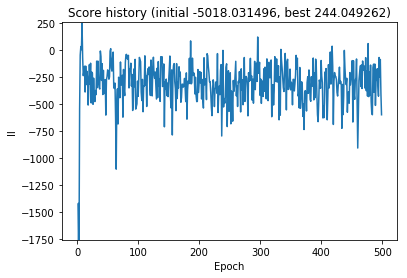

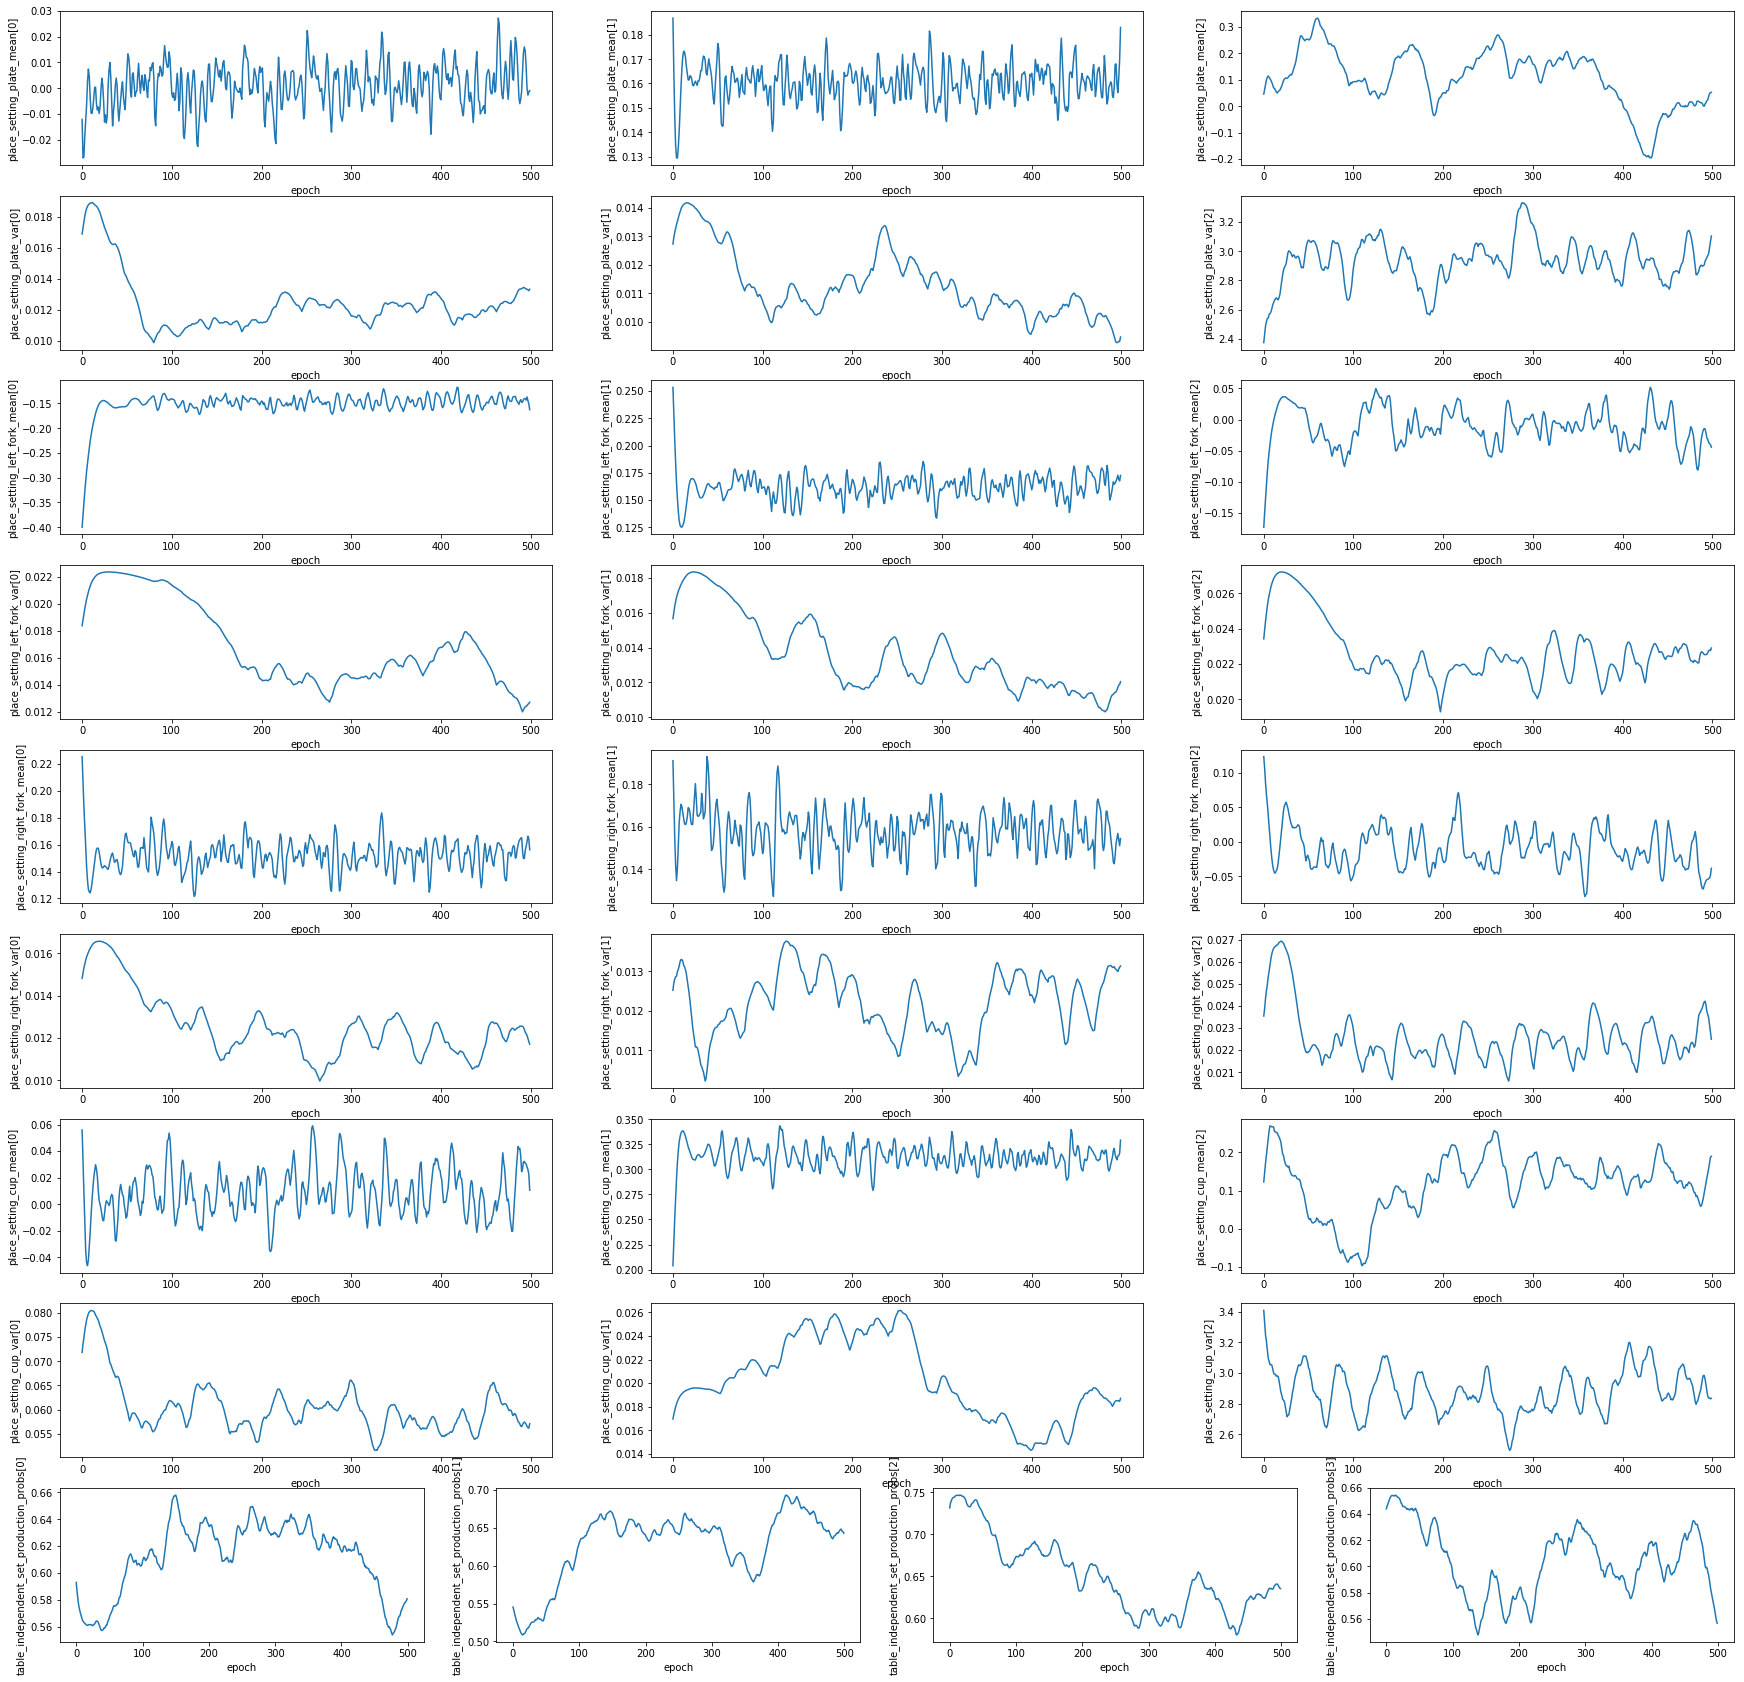

In [73]:
scores_over_time_adjusted = np.array(score_history)
max_score = np.max(scores_over_time_adjusted)
#scores_over_time_adjusted = np.log(scores_over_time_adjusted - min_score + 1.)
plt.plot(score_history)
plt.title("Score history (initial %f, best %f)" % (score_history[0], max_score))
plt.ylabel("ll")
plt.xlabel("Epoch")
plt.ylim(max_score - 2000, max_score + 10)
print(pyro.get_param_store().get_all_param_names())
names_of_interest = ["place_setting_plate_mean", "place_setting_plate_var", 
                     "place_setting_left_fork_mean", "place_setting_left_fork_var",
                     "place_setting_right_fork_mean", "place_setting_right_fork_var",
                     #"place_setting_left_spoon_mean", "place_setting_left_spoon_var",
                     #"place_setting_right_spoon_mean", "place_setting_right_spoon_var",
                     "place_setting_cup_mean", "place_setting_cup_var",
                     #"place_setting_production_weights",
                     "table_independent_set_production_probs"]
plt.figure().set_size_inches(30, 30)
for i, name in enumerate(names_of_interest):
    val_epochs = [k for k, d in enumerate(param_val_history) if name in d.keys()]
    vals_across_time = np.vstack([d[name] for d in param_val_history if name in d.keys()]).T
    print(vals_across_time.shape)
    num_vals = vals_across_time.shape[0]
    for j in range(num_vals):
        plt.subplot(len(names_of_interest), num_vals, i*num_vals + j + 1)
        plt.plot(val_epochs, vals_across_time[j, :])
        plt.ylabel(name + "[%d]" % j)
        plt.xlabel("epoch")
#plt.tight_layout()

In [74]:
import scene_generation.data.dataset_utils as dataset_utils

# Score the outlier dataset
outlier_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_generated_with_left_knife_and_spoon_rules.yaml")
scores_outlier = []
observed_trees_outlier = []
for i, env in enumerate(outlier_dataset):
    observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
    observed_trees_outlier.append(observed_tree)
    scores_outlier.append(joint_score.item())
    print("Scored outlier %d at %f" % (i, joint_score))
    
# Score the test dataset
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_test")
scores_test = []
observed_trees_test = []
for i, env in enumerate(test_dataset):
    observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
    observed_trees_test.append(observed_tree)
    scores_test.append(joint_score.item())
    print("Scored test %d at %f" % (i, joint_score))

Scored outlier 0 at 15.995678
Scored outlier 1 at 23.911982
Scored outlier 2 at 17.158346
Scored outlier 3 at -194.232258
Scored outlier 4 at 75.386328
Scored outlier 5 at 44.753752
Scored outlier 6 at -54.508735
Scored outlier 7 at 64.800236
Scored outlier 8 at -154.863836
Scored outlier 9 at 42.154121
Scored outlier 10 at 27.207623
Scored outlier 11 at -27.068377
Scored outlier 12 at 70.746983
Scored outlier 13 at 62.789991
Scored outlier 14 at 45.240471
Scored outlier 15 at -83.925052
Scored outlier 16 at 52.080782
Scored outlier 17 at 28.072361
Scored outlier 18 at 1.004862
Scored outlier 19 at -139.247599
Scored outlier 20 at -3.719760
Scored outlier 21 at 31.810245
Scored outlier 22 at -102.635977
Scored outlier 23 at 39.860470
Scored outlier 24 at 14.668147
Scored outlier 25 at 33.320254
Scored outlier 26 at 5.706604
Scored outlier 27 at 11.598192
Scored outlier 28 at 5.883511
Scored outlier 29 at 15.977971
Scored outlier 30 at -3.719760
Scored outlier 31 at 54.297222
Scored out

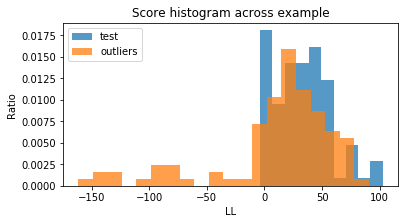

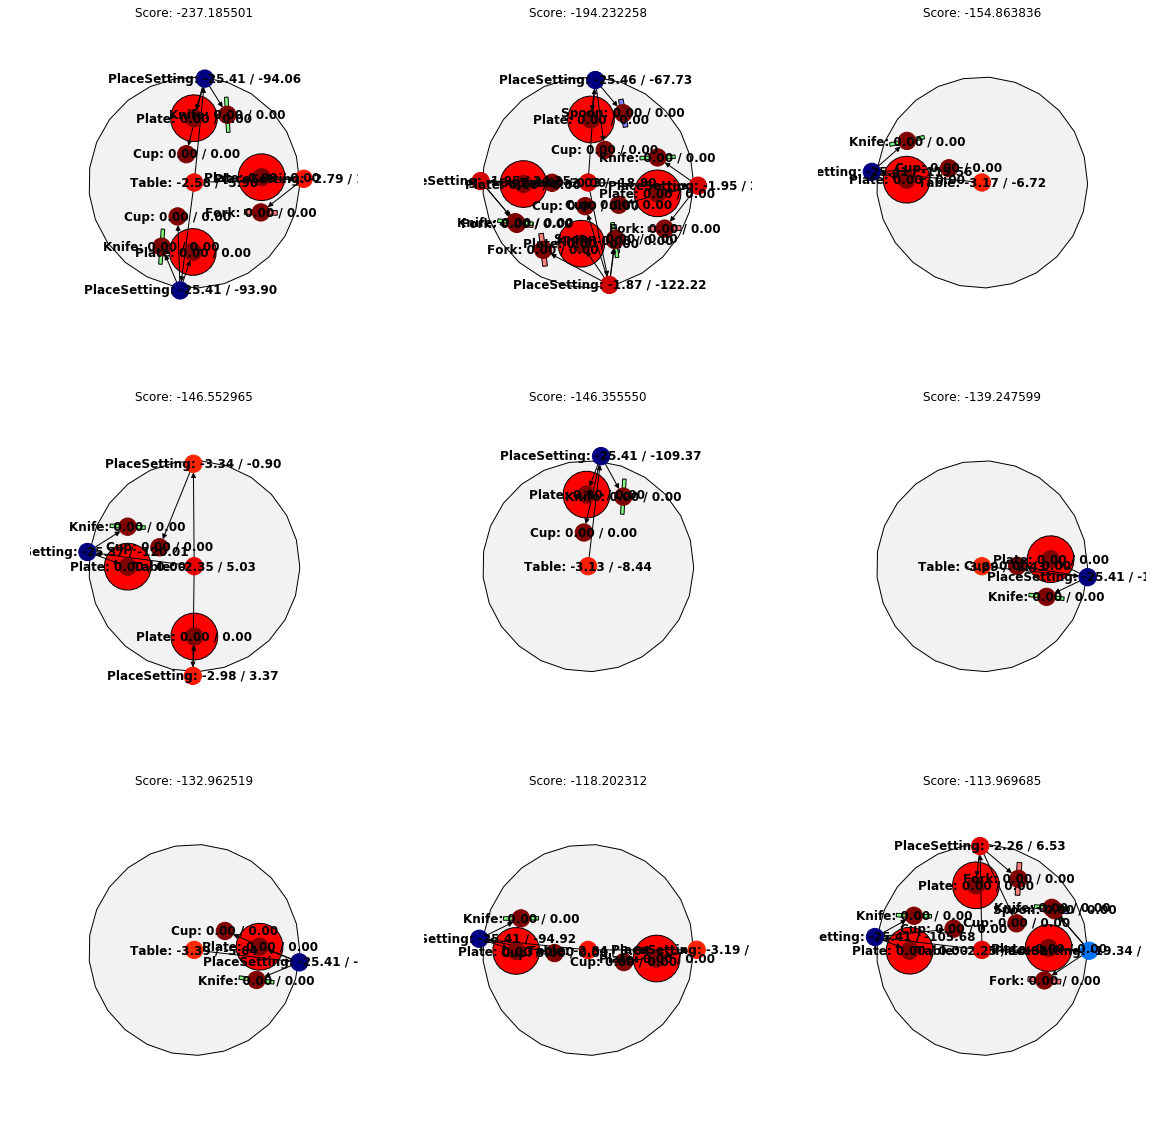

In [75]:
# Sort
inds_in_ascending_order = np.argsort(scores_outlier)

plt.figure().set_size_inches(6, 3)
bins = np.arange(min(np.min(scores_outlier), np.min(scores_test)),
                 max(np.max(scores_outlier), np.max(scores_test)), 20)
plt.hist(scores_test, normed=True, bins=10, label="test", alpha=0.75)
plt.hist(scores_ascending, normed=True, bins=20, label="outliers", alpha=0.75)
plt.title("Score histogram across example")
plt.ylabel("Ratio")
plt.xlabel("LL")
plt.legend()

plt.figure().set_size_inches(20, 20)
for i in range(3):
    for j in range(3):
        ind = i*3 + j
        plt.subplot(3, 3, ind + 1)
        ind_into_orig = inds_in_ascending_order[ind]
        plt.title("Score %f" % scores_outlier[ind_into_orig])
        DrawYamlEnvironmentPlanar(outlier_dataset[ind_into_orig], base_environment_type="table_setting", ax=plt.gca())
        draw_parse_tree(observed_trees_outlier[ind_into_orig], label_name=True, label_score=True)

Unhandled exception in drawyamlenv


(-0.5, 1439.5, 1439.5, -0.5)

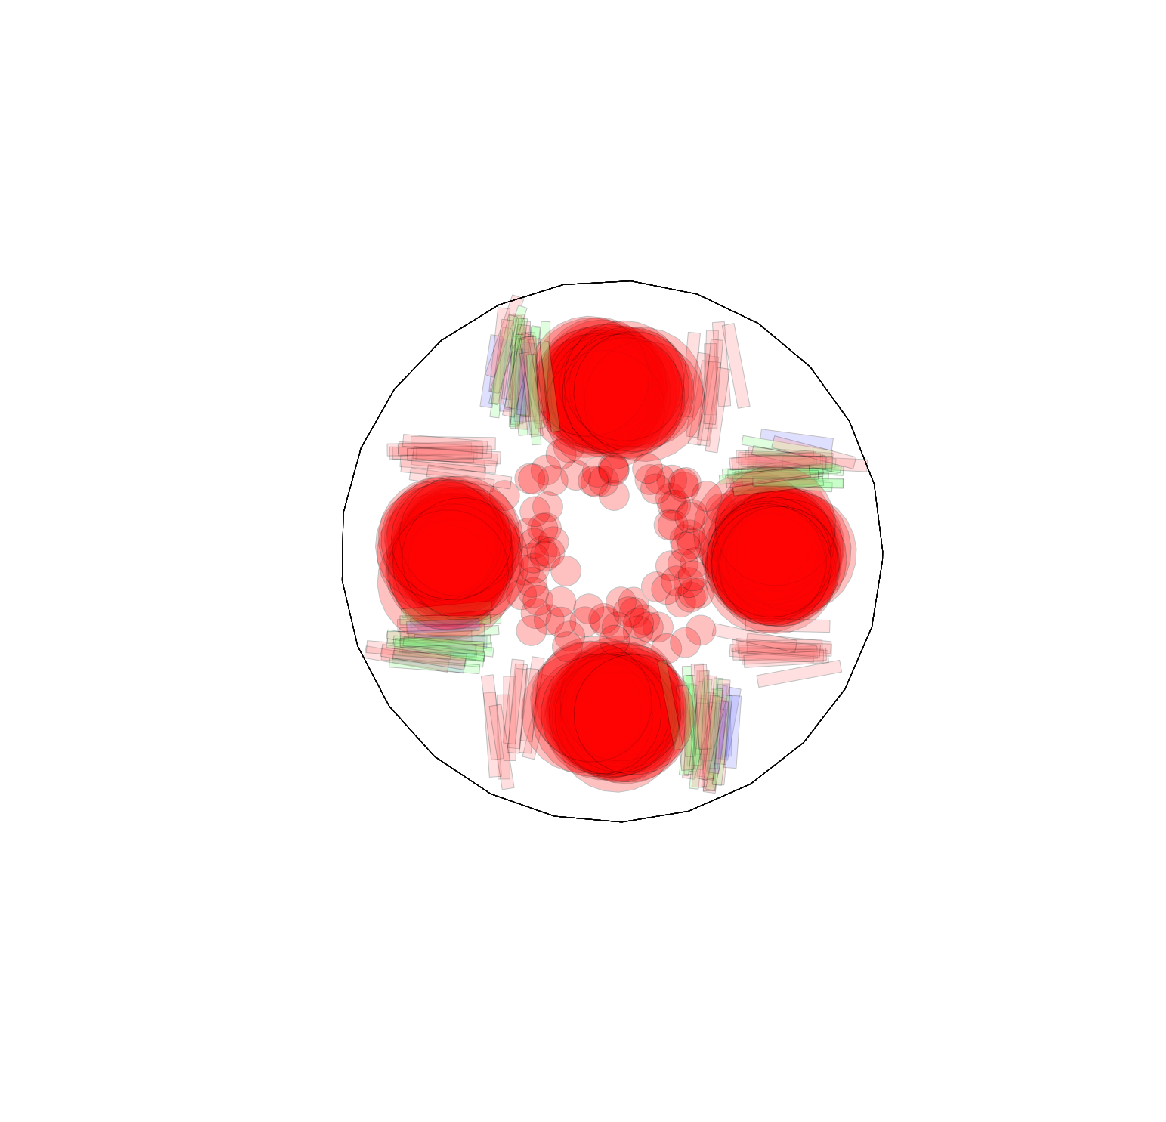

In [98]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
images = []
for k in range(50):
    plt.gca().clear()
    trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
    parse_tree = trace.nodes["_RETURN"]["value"]        
    score = trace.log_prob_sum()
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    try:
        DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
    except:
        print("Unhandled exception in drawyamlenv")
    #draw_parse_tree(parse_tree, label_name=False, label_score=False)
    plt.title("")
    plt.gca().axis('off')
    images.append(dataset_utils.fig2data(plt.gcf()).copy())
plt.gca().clear()
for im in images:
    plt.imshow(im, alpha=0.25)
plt.gca().axis('off')

In [ ]:
# Generate a bunch of envs + their parse trees
generated_envs_and_trees = []
for k in range(100):
    parse_tree = generate_unconditioned_parse_tree()
    generated_envs_and_trees.append((
        convert_tree_to_yaml_env(parse_tree),
        parse_tree))

In [ ]:
# Instead train on environments in which I have perfect parse trees
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.5, 0.5)}
optimizer = Adam(adam_params)
    
pyro.param("place_setting_left_fork_mean").data[0] = 0.0
# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    random.shuffle(generated_envs_and_trees)
    for env, best_observed_tree in generated_envs_and_trees[:5]:
        best_score, _ = score_tree(best_observed_tree)
        losses.append(-1. * best_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in best_observed_tree.nodes])
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    #print("Val: ", pyro.param("place_setting_left_fork_mean").detach().cpu().numpy())
    #print("Grad: ", pyro.get_param_store()._params["place_setting_left_fork_mean"].grad)
    #for param in params:
    #   param.data + param.grad*100
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
    #print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    #print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

In [ ]:
pyro.get_param_store()._params["place_setting_left_fork_var"]

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_env, observed_tree in generated_envs_and_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    

plt.tight_layout()